In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import re
import nltk
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import time

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from sklearn import preprocessing

In [ ]:
articles = pd.read_csv('https://raw.githubusercontent.com/nxz96/Msc/main/sex_diff_screenings.csv')

In [ ]:
def wss(R, y_true, y_pred):
    cfmat = confusion_matrix(y_true, y_pred)
    tn_, fp_, fn_, tp_ = cfmat.ravel() # instead of doing a call for each
    N = np.sum(cfmat)
    if N <= 0:
      print("N = {}!!!".format(N))
    return (tn_ + fn_)/N - (1 - R)

def wss95(y_true, y_pred):
    return wss(0.95, y_true, y_pred)

def print_plot(index):
    example = articles[articles.index == index][['titleabstract', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('category:', example[1])

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS and word not in UNWANTED_WORDS) # remove stopwords and UNWANTED_WORDS from text
    return text


def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever

In [ ]:
rows, cols = articles.shape
print('INIT: Data size: Num of rows: ',rows, ' Num of cols: ',cols)

INIT: Data size: Num of rows:  4000  Num of cols:  23


In [ ]:
articles = articles.dropna(subset=["Decision"])
rows, cols = articles.shape
print('Removed nan from notes: Data size: Num of rows: ',rows, ' Num of cols: ',cols)

Removed nan from notes: Data size: Num of rows:  4000  Num of cols:  23


In [ ]:
bool1 = pd.isnull(articles['Abstract'])
print(len(articles[bool1]))

368


In [ ]:
for i, row in articles[bool1].iterrows():
    articles.at[i,'abstract'] = " "

articles = articles.dropna(subset=["Abstract"])
rows, cols = articles.shape
print('Removed nan from abstract: Data size: Num of rows: ',rows, ' Num of cols: ',cols)

Removed nan from abstract: Data size: Num of rows:  3632  Num of cols:  24


In [ ]:
articles["category"] = "None"

included = 0
excluded = 0 
maybe = 0
labelled = 0
others = 0
unlabelled = 0
labels = 0

index = 0
max_len = -1


for i, row in articles.iterrows():
    
    row = articles.loc[i, "Decision"]
    
    if "Included" in row:
            articles.at[i,'category'] = "Included"
            included = included + 1
    elif "Excluded" in row:
            articles.at[i,'category'] = "Excluded"
            excluded = excluded + 1
    else:
            others = others + 1
                
            
print('Labelled data : ',labelled)                
print('Unlabelled data: ',unlabelled)
print('included: ',included) 
print('excluded: ',excluded) 

Labelled data :  0
Unlabelled data:  0
included:  224
excluded:  3408


In [ ]:
for i, row in articles.iterrows():
    row = articles.loc[i, "category"]
    if row == "None":
        r = articles.loc[i, "Decision"]
        articles.at[i,'category'] = np.nan
        
articles = articles.dropna(subset=["category"])
rows, cols = articles.shape
print('Removed nan from category: Data size: Num of rows: ',rows, ' Num of cols: ',cols)

Removed nan from category: Data size: Num of rows:  3632  Num of cols:  25


In [ ]:
articles["titleabstract"] = articles["Title"] + " " + articles["Abstract"]

In [ ]:
col = ['category', 'titleabstract']
articles = articles[col]
# articles = articles[pd.notnull(articles['titleabstract'])]
articles.columns = ['category', 'titleabstract']
articles['category_id'] = articles['category'].factorize()[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
sample = 20
print("Before removing UNWANTED WORDS: data_id ",sample)
print_plot(sample)
print("\n")

Before removing UNWANTED WORDS: data_id  20
Racial disparities in receipt of standard chemoradiation in anal squamous cell carcinoma, an analysis of the National Cancer Database Background: Standard treatment for locally advanced anal squamous cell carcinoma (SCC) consists of concurrent chemoradiation. We evaluated whether racial differences exist in the receipt of standard treatment and its association with survival. Method(s): From the National Cancer Database, we identified patients diagnosed with anal SCC (Stages 2-3) between 2004 and 2015. Using logistic regression, we evaluated racial differences in the probability of receiving standard chemoradiation. We used Cox proportional hazards models to evaluate associations between race, receipt of standard therapy and survival. Result(s): Our analysis included 19,835 patients. Patients receiving standard chemoradiation had better survival than patients receiving nonstandard therapy (hazard ratio [HR] 0.64; 95% confidence interval [CI] 0

In [ ]:
import nltk
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
UNWANTED_WORDS = ['results', 'objectives', 'methods', 'design', 'study population', 'measurements', 'conclusions', 'materials', 'methods', 'limitations', 'setting', 'patients', 'purpose', 'intervention', 'main outcome', 'measures', 'background']
articles['titleabstract'] = articles['titleabstract'].apply(clean_text)
articles['titleabstract'] = articles['titleabstract'].str.replace('\d+', '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [ ]:
articles = articles.drop_duplicates(keep='first')

In [ ]:
x,y = np.asarray(articles["titleabstract"]),np.asarray(articles["category_id"])

In [ ]:
x_tokenized = [[w for w in sentence.split(" ") if w != ""] for sentence in x]

In [ ]:
import gensim

model = gensim.models.Word2Vec(x_tokenized,
                 size=100
                )

In [ ]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
    
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
      
        for word in temp_vocab:
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()

In [ ]:
sequencer = Sequencer(all_words = [token for seq in x_tokenized for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = model.wv
             )

In [ ]:
x_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in x_tokenized])
print(x_vecs.shape)

(3630, 1500)


In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50)
pca_model.fit(x_vecs)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

Sum of variance ratios:  0.567928602791211


In [ ]:
x_comps = pca_model.transform(x_vecs)
x_comps.shape

(3630, 50)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy='minority')

undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
X_over, y_over = oversample.fit_resample(x_comps, y)

X_under, y_under = undersample.fit_resample(x_comps, y)

In [ ]:
print(X_over.shape)
print(X_under.shape)
print(y_over.shape)
print(y_under.shape)

(6812, 50)
(448, 50)
(6812,)
(448,)


In [ ]:
from collections import Counter

print("Labels count : ",Counter(y))
print("Labels count after oversampling : ",Counter(y_over))
print("Labels count after undersampling : ",Counter(y_under))

Labels count :  Counter({0: 3406, 1: 224})
Labels count after oversampling :  Counter({0: 3406, 1: 3406})
Labels count after undersampling :  Counter({0: 224, 1: 224})


In [ ]:
from sklearn.model_selection import train_test_split
X_train_over, X_test_over, Y_train_over, Y_test_over = train_test_split(X_over,y_over, test_size = 0.20, random_state = 2021, stratify=y_over)

print(X_train_over.shape)
print(X_test_over.shape)
print(Y_train_over.shape)
print(Y_test_over.shape)

(5449, 50)
(1363, 50)
(5449,)
(1363,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train_under, X_test_under, Y_train_under, Y_test_under = train_test_split(X_under,y_under, test_size = 0.20, random_state = 2021, stratify=y_under)

print(X_train_under.shape)
print(X_test_under.shape)
print(Y_train_under.shape)
print(Y_test_under.shape)

(358, 50)
(90, 50)
(358,)
(90,)


**Oversample Results**

In [ ]:
svm_classifier_b = SVC(probability=True)
svm_classifier_b.fit(X_train_over, Y_train_over)

pred_b_svm = svm_classifier_b.predict(X_test_over)

prob_y_roc_b = svm_classifier_b.predict_proba(X_test_over)
prob_y_roc_b = [p[1] for p in prob_y_roc_b]


print('Precision: %.3f' % precision_score(Y_test_over, pred_b_svm))
print('Recall: %.3f' % recall_score(Y_test_over, pred_b_svm))
print('Accuracy: %.3f' % accuracy_score(Y_test_over, pred_b_svm))
print('F1 Score: %.3f' % f1_score(Y_test_over, pred_b_svm))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_over, prob_y_roc_b))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_over, pred_b_svm))
print('wss95: %.3f' % wss95(Y_test_over, pred_b_svm))

Precision: 0.938
Recall: 0.996
Accuracy: 0.965
F1 Score: 0.966
roc_auc Score: 0.997
cohen kappa score: 0.930
wss95: 0.420


In [ ]:
rfc_b = RandomForestClassifier()
rfc_b.fit(X_train_over,Y_train_over)

pred_b_rfc = rfc_b.predict(X_test_over)

prob_y_roc_b_rfc = rfc_b.predict_proba(X_test_over)
prob_y_roc_b_rfc = [p[1] for p in prob_y_roc_b_rfc]


print('Precision: %.3f' % precision_score(Y_test_over, pred_b_rfc))
print('Recall: %.3f' % recall_score(Y_test_over, pred_b_rfc))
print('Accuracy: %.3f' % accuracy_score(Y_test_over, pred_b_rfc))
print('F1 Score: %.3f' % f1_score(Y_test_over, pred_b_rfc))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_over, prob_y_roc_b_rfc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_over, pred_b_rfc))
print('wss95: %.3f' % wss95(Y_test_over, pred_b_rfc))

Precision: 1.000
Recall: 1.000
Accuracy: 1.000
F1 Score: 1.000
roc_auc Score: 1.000
cohen kappa score: 1.000
wss95: 0.450


In [ ]:
XGB_b = XGBClassifier()
XGB_b.fit(X_train_over, Y_train_over)

pred_b_xgb = XGB_b.predict(X_test_over)

prob_y_roc_b_xgb = rfc_b.predict_proba(X_test_over)
prob_y_roc_b_xgb = [p[1] for p in prob_y_roc_b_xgb]

print('Precision: %.3f' % precision_score(Y_test_over, pred_b_xgb))
print('Recall: %.3f' % recall_score(Y_test_over, pred_b_xgb))
print('Accuracy: %.3f' % accuracy_score(Y_test_over, pred_b_xgb))
print('F1 Score: %.3f' % f1_score(Y_test_over, pred_b_xgb))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_over, prob_y_roc_b_xgb))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_over, pred_b_xgb))
print('wss95: %.3f' % wss95(Y_test_over, pred_b_xgb))

Precision: 0.871
Recall: 0.979
Accuracy: 0.917
F1 Score: 0.922
roc_auc Score: 1.000
cohen kappa score: 0.834
wss95: 0.388


**Undersample Results**

In [ ]:
svm_classifier_u = SVC(probability=True)
svm_classifier_u.fit(X_train_under, Y_train_under)

pred_u_svm = svm_classifier_b.predict(X_test_under)

prob_y_roc_u = svm_classifier_b.predict_proba(X_test_under)
prob_y_roc_u = [p[1] for p in prob_y_roc_u]


print('Precision: %.3f' % precision_score(Y_test_under, pred_u_svm))
print('Recall: %.3f' % recall_score(Y_test_under, pred_u_svm))
print('Accuracy: %.3f' % accuracy_score(Y_test_under, pred_u_svm))
print('F1 Score: %.3f' % f1_score(Y_test_under, pred_u_svm))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_under, prob_y_roc_u))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_under, pred_u_svm))
print('wss95: %.3f' % wss95(Y_test_under, pred_u_svm))

Precision: 0.978
Recall: 1.000
Accuracy: 0.989
F1 Score: 0.989
roc_auc Score: 1.000
cohen kappa score: 0.978
wss95: 0.439


In [ ]:
rfc_u = RandomForestClassifier()
rfc_u.fit(X_train_under,Y_train_under)

pred_u_rfc = rfc_b.predict(X_test_under)

prob_y_roc_u_rfc = rfc_b.predict_proba(X_test_under)
prob_y_roc_u_rfc = [p[1] for p in prob_y_roc_u_rfc]


print('Precision: %.3f' % precision_score(Y_test_under, pred_u_rfc))
print('Recall: %.3f' % recall_score(Y_test_under, pred_u_rfc))
print('Accuracy: %.3f' % accuracy_score(Y_test_under, pred_u_rfc))
print('F1 Score: %.3f' % f1_score(Y_test_under, pred_u_rfc))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_under, prob_y_roc_u_rfc))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_under, pred_u_rfc))
print('wss95: %.3f' % wss95(Y_test_under, pred_u_rfc))

Precision: 1.000
Recall: 1.000
Accuracy: 1.000
F1 Score: 1.000
roc_auc Score: 1.000
cohen kappa score: 1.000
wss95: 0.450


In [ ]:
XGB_u = XGBClassifier()
XGB_u.fit(X_train_under, Y_train_under)

pred_u_xgb = XGB_b.predict(X_test_under)

prob_y_roc_u_xgb = rfc_b.predict_proba(X_test_under)
prob_y_roc_u_xgb = [p[1] for p in prob_y_roc_u_xgb]

print('Precision: %.3f' % precision_score(Y_test_under, pred_u_xgb))
print('Recall: %.3f' % recall_score(Y_test_under, pred_u_xgb))
print('Accuracy: %.3f' % accuracy_score(Y_test_under, pred_u_xgb))
print('F1 Score: %.3f' % f1_score(Y_test_under, pred_u_xgb))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(Y_test_under, prob_y_roc_u_xgb))
print('cohen kappa score: %.3f' % cohen_kappa_score(Y_test_under, pred_u_xgb))
print('wss95: %.3f' % wss95(Y_test_under, pred_u_xgb))

Precision: 0.938
Recall: 1.000
Accuracy: 0.967
F1 Score: 0.968
roc_auc Score: 1.000
cohen kappa score: 0.933
wss95: 0.417


** STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }**

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

precision_stratified = []
recall_stratified = []
accuracy_stratified = []
f1score_stratified = []
roc_stratified = []
cohenkappa_stratified = []
wss95_stratified = []

svm_classifier_skf = SVC(probability=True)


for train_index, test_index in skf.split(x_comps, y):
    x_train_fold_o, x_test_fold_o = X_over[train_index], X_over[test_index]
    y_train_fold_o, y_test_fold_o = y_over[train_index], y_over[test_index]
    
    svm_classifier_skf.fit(x_train_fold_o, y_train_fold_o)

    pred_skf_svm = svm_classifier_skf.predict(x_test_fold_o)

    prob_y_roc_skf = svm_classifier_skf.predict_proba(x_test_fold_o)
    prob_y_roc_skf = [p[1] for p in prob_y_roc_skf]
    precision_stratified.append(precision_score(y_test_fold_o, pred_skf_svm))
    recall_stratified.append(recall_score(y_test_fold_o, pred_skf_svm))
    accuracy_stratified.append(accuracy_score(y_test_fold_o, pred_skf_svm))
    f1score_stratified.append(f1_score(y_test_fold_o, pred_skf_svm))
    roc_stratified.append(metrics.roc_auc_score(y_test_fold_o, prob_y_roc_skf))
    cohenkappa_stratified.append(cohen_kappa_score(y_test_fold_o, pred_skf_svm))
    wss95_stratified.append(wss95(y_test_fold_o, pred_skf_svm))


print('Precision: %.3f' % precision_score(y_test_fold_o, pred_skf_svm))
print('Recall: %.3f' % recall_score(y_test_fold_o, pred_skf_svm))
print('Accuracy: %.3f' % accuracy_score(y_test_fold_o, pred_skf_svm))
print('F1 Score: %.3f' % f1_score(y_test_fold_o, pred_skf_svm))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(y_test_fold_o, prob_y_roc_skf))
print('cohen kappa score: %.3f' % cohen_kappa_score(y_test_fold_o, pred_skf_svm))
print('wss95: %.3f' % wss95(y_test_fold_o, pred_skf_svm))



print('List of possible Precision:', precision_stratified)
print('\nMaximum Precision That can be obtained from this model is:',
      max(precision_stratified)*100, '%')
print('\nMinimum Precision:',
      min(precision_stratified)*100, '%')
print('\nOverall Precision:',
      mean(precision_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(precision_stratified))

print('List of possible Recall:', recall_stratified)
print('\nMaximum Recall That can be obtained from this model is:',
      max(recall_stratified)*100, '%')
print('\nMinimum Recall:',
      min(recall_stratified)*100, '%')
print('\nOverall Recall:',
      mean(recall_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(recall_stratified))

print('List of possible accuracy:', accuracy_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(accuracy_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(accuracy_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(accuracy_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(accuracy_stratified))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Precision: 0.000
Recall: 0.000
Accuracy: 0.937
F1 Score: 0.000
roc_auc Score: 0.824
cohen kappa score: 0.000
wss95: 0.950
List of possible Precision: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Maximum Precision That can be obtained from this model is: 0.0 %

Minimum Precision: 0.0 %

Overall Precision: 0.0 %

Standard Deviation is: 0.0
List of possible Recall: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Maximum Recall That can be obtained from this model is: 0.0 %

Minimum Recall: 0.0 %

Overall Recall: 0.0 %

Standard Deviation is: 0.0
List of possible accuracy: [0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9366391184573003, 0.9366391184573003, 0.9366391184573003, 0.9366391184573003]

Maximum Accuracy That can be obtained from this model is: 93.93939393939394 %

Minimum Accuracy: 93.66391184573003 %

Overall Accuracy: 93.82920110192839 %

Standard Deviation is: 0.0014225834145849242


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rfc_skf = RandomForestClassifier()
rfc_skf.fit(x_train_fold_o,y_train_fold_o)

pred_skf_rfc = rfc_b.predict(x_test_fold_o)

prob_y_roc_skf_rfc = rfc_b.predict_proba(x_test_fold_o)
prob_y_roc_skf_rfc = [p[1] for p in prob_y_roc_skf_rfc]


print('Precision: %.3f' % precision_score(y_test_fold_o, pred_skf_rfc))
print('Recall: %.3f' % recall_score(y_test_fold_o, pred_skf_rfc))
print('Accuracy: %.3f' % accuracy_score(y_test_fold_o, pred_skf_rfc))
print('F1 Score: %.3f' % f1_score(y_test_fold_o, pred_skf_rfc))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(y_test_fold_o, prob_y_roc_skf_rfc))
print('cohen kappa score: %.3f' % cohen_kappa_score(y_test_fold_o, pred_skf_rfc))
print('wss95: %.3f' % wss95(y_test_fold_o, pred_skf_rfc))

Precision: 1.000
Recall: 1.000
Accuracy: 1.000
F1 Score: 1.000
roc_auc Score: 1.000
cohen kappa score: 1.000
wss95: 0.887


In [ ]:
XGB_skf = XGBClassifier()
XGB_skf.fit(X_train_under, Y_train_under)

pred_skf_xgb = XGB_b.predict(x_test_fold_o)

prob_y_roc_skf_xgb = rfc_skf.predict_proba(x_test_fold_o)
prob_y_roc_skf_xgb = [p[1] for p in prob_y_roc_skf_xgb]

print('Precision: %.3f' % precision_score(y_test_fold_o, pred_skf_xgb))
print('Recall: %.3f' % recall_score(y_test_fold_o, pred_skf_xgb))
print('Accuracy: %.3f' % accuracy_score(y_test_fold_o, pred_skf_xgb))
print('F1 Score: %.3f' % f1_score(y_test_fold_o, pred_skf_xgb))
print('roc_auc Score: %.3f' % metrics.roc_auc_score(y_test_fold_o, prob_y_roc_skf_xgb))
print('cohen kappa score: %.3f' % cohen_kappa_score(y_test_fold_o, pred_skf_xgb))
print('wss95: %.3f' % wss95(y_test_fold_o, pred_skf_xgb))

Precision: 0.310
Recall: 0.957
Accuracy: 0.862
F1 Score: 0.468
roc_auc Score: 0.834
cohen kappa score: 0.412
wss95: 0.754


>1, train: 0.983, test: 0.965
>2, train: 0.983, test: 0.965
>3, train: 0.983, test: 0.965
>4, train: 0.983, test: 0.965
>5, train: 0.983, test: 0.965
>6, train: 0.983, test: 0.965
>7, train: 0.983, test: 0.965
>8, train: 0.983, test: 0.965
>9, train: 0.983, test: 0.965
>10, train: 0.983, test: 0.965
>11, train: 0.983, test: 0.965
>12, train: 0.983, test: 0.965
>13, train: 0.983, test: 0.965
>14, train: 0.983, test: 0.965
>15, train: 0.983, test: 0.965
>16, train: 0.983, test: 0.965
>17, train: 0.983, test: 0.965
>18, train: 0.983, test: 0.965
>19, train: 0.983, test: 0.965
>20, train: 0.983, test: 0.965


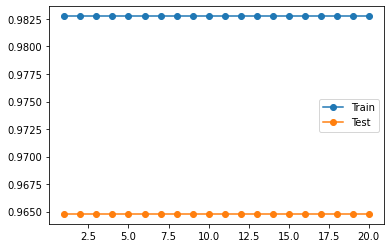

In [ ]:
from matplotlib import pyplot
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = SVC()
	# fit model on the training dataset
	model.fit(X_train_over, Y_train_over)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train_over)
	train_acc = accuracy_score(Y_train_over, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test_over)
	test_acc = accuracy_score(Y_test_over, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs number of neighbors
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()